In [5]:
import numpy as np
from glob import glob
import os

In [6]:
ls ../monit_npy/

nn_rhorho_Variant-All_Unweighted_False_NO_NUM_CLASSES_10/
nn_rhorho_Variant-All_Unweighted_False_NO_NUM_CLASSES_11/
nn_rhorho_Variant-All_Unweighted_False_NO_NUM_CLASSES_12/
nn_rhorho_Variant-All_Unweighted_False_NO_NUM_CLASSES_13/
nn_rhorho_Variant-All_Unweighted_False_NO_NUM_CLASSES_14/
nn_rhorho_Variant-All_Unweighted_False_NO_NUM_CLASSES_15/
nn_rhorho_Variant-All_Unweighted_False_NO_NUM_CLASSES_16/
nn_rhorho_Variant-All_Unweighted_False_NO_NUM_CLASSES_17/
nn_rhorho_Variant-All_Unweighted_False_NO_NUM_CLASSES_18/
nn_rhorho_Variant-All_Unweighted_False_NO_NUM_CLASSES_19/
nn_rhorho_Variant-All_Unweighted_False_NO_NUM_CLASSES_2/
nn_rhorho_Variant-All_Unweighted_False_NO_NUM_CLASSES_20/
nn_rhorho_Variant-All_Unweighted_False_NO_NUM_CLASSES_21/
nn_rhorho_Variant-All_Unweighted_False_NO_NUM_CLASSES_22/
nn_rhorho_Variant-All_Unweighted_False_NO_NUM_CLASSES_23/
nn_rhorho_Variant-All_Unweighted_False_NO_NUM_CLASSES_24/
nn_rhorho_Variant-All_Unweighted_False_NO_NUM_CLASSES_25/
nn_rhorho_Varia

In [7]:
filenames = [f'../monit_npy/nn_rhorho_Variant-All_Unweighted_False_NO_NUM_CLASSES_{i}' for i in range(2,51)]

In [8]:
ls ../monit_npy/nn_rhorho_Variant-All_Unweighted_False_NO_NUM_CLASSES_50

softmax_calc_w.npy   softmax_preds_w.npy


In [9]:
filenames[0]

'../monit_npy/nn_rhorho_Variant-All_Unweighted_False_NO_NUM_CLASSES_2'

In [13]:
def calculate_metrics(directory, num_class):
    calc_w = np.load(os.path.join(directory, 'softmax_calc_w.npy'))
    preds_w = np.load(os.path.join(directory, 'softmax_preds_w.npy'))
    calc_w = calc_w / np.tile(np.reshape(np.sum(calc_w, axis=1), (-1, 1)), (1, num_class))
    pred_arg_maxs = np.argmax(preds_w, axis=1)
    calc_arg_maxs = np.argmax(calc_w, axis=1)
    calc_pred_argmaxs_distances = np.min(
       np.stack(
           [np.abs(pred_arg_maxs-calc_arg_maxs), (num_class - np.abs(pred_arg_maxs-calc_arg_maxs))]
       ), axis=0)
    acc0 = (calc_pred_argmaxs_distances <= 0).mean()
    acc1 = (calc_pred_argmaxs_distances <= 1).mean()
    acc2 = (calc_pred_argmaxs_distances <= 2).mean()
    acc3 = (calc_pred_argmaxs_distances <= 3).mean()
    
    mse = np.mean(calc_pred_argmaxs_distances)
    l1_delta_w = np.mean(np.abs(calc_w - preds_w))/num_class
    l2_delta_w = np.sqrt(np.mean((calc_w - preds_w)**2))/num_class
    
    return np.array([acc0, acc1, acc2, acc3, mse, l1_delta_w, l2_delta_w])

In [14]:
metrics = [calculate_metrics(filenames[i], i+2) for i in range(49)]

In [15]:
import matplotlib.pyplot as plt

In [16]:
metrics = np.stack(metrics)

# Accuracy

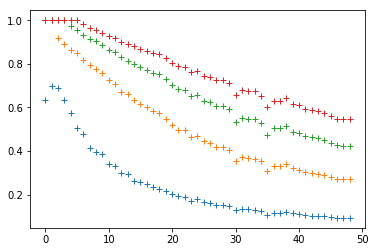

In [76]:
plt.plot(metrics[:, 0],'+')
plt.plot(metrics[:, 1],'+')
plt.plot(metrics[:, 2],'+')
plt.plot(metrics[:, 3],'+')


# MSE

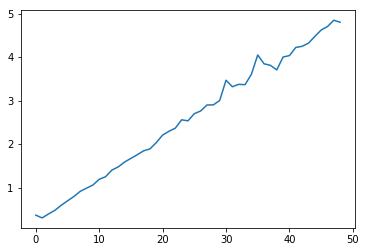

In [85]:
plt.plot(metrics[:, 5])



# L1 Distance

Text(0,0.5,'l1')

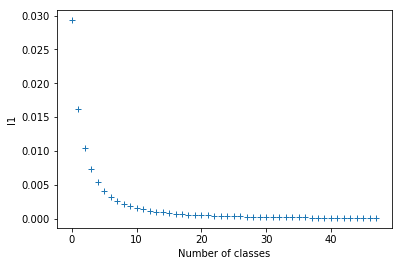

In [88]:
plt.plot(metrics[1:, 6], '+')
plt.xlabel("Number of classes")
plt.ylabel('l1')

# L2 Distance

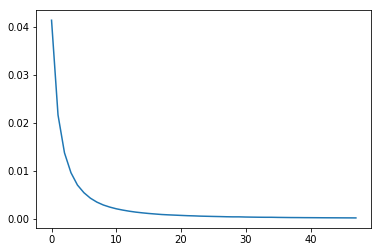

In [23]:
plt.plot(metrics[1:, 7])

# ROC AUC score

In [145]:
from sklearn.metrics import roc_auc_score
def calculate_roc_auc(pred_w, calc_w, index_a, index_b):
    n, num_classes = calc_w.shape
    true_labels = np.concatenate([np.ones(n), np.zeros(n)])
    preds = np.concatenate([pred_w[:, index_a], pred_w[:, index_a]])
    weights = np.concatenate([calc_w[:, index_a], calc_w[:, index_b]])

    return roc_auc_score(true_labels, preds, sample_weight=weights)

In [159]:
def test_roc_auc(directory, num_class):
    calc_w = np.load(os.path.join(directory, 'softmax_calc_w.npy'))
    preds_w = np.load(os.path.join(directory, 'softmax_preds_w.npy'))
    for i in range(0, num_class):
         print(i, 'roc_auc: {}'.format(calculate_roc_auc(preds_w, calc_w, 0, i)), 'maxroc_auc: {}'.format(calculate_roc_auc(calc_w, calc_w, 0, i)))

In [160]:
i = 5
test_roc_auc(filenames[i], i+2)

0 roc_auc: 0.5000000000000031 maxroc_auc: 0.5000000000000064
1 roc_auc: 0.551783682890363 maxroc_auc: 0.5557151267562858
2 roc_auc: 0.6563347427177485 maxroc_auc: 0.6666483139876462
3 roc_auc: 0.709397709758139 maxroc_auc: 0.72217833564523
4 roc_auc: 0.6575931969779887 maxroc_auc: 0.666438096842351
5 roc_auc: 0.5527463138136285 maxroc_auc: 0.5551927056728906
6 roc_auc: 0.5000000000000031 maxroc_auc: 0.5000000000000064


# Accuracy distance

In [78]:
def plot_distr(directory, num_class):
    calc_w = np.load(os.path.join(directory, 'softmax_calc_w.npy'))
    preds_w = np.load(os.path.join(directory, 'softmax_preds_w.npy'))
    pred_arg_maxs = np.argmax(preds_w, axis=1)
    calc_arg_maxs = np.argmax(calc_w, axis=1)
    calc_pred_argmaxs_distances = np.min(
       np.stack(
           [np.abs(pred_arg_maxs-calc_arg_maxs), (num_class - np.abs(pred_arg_maxs-calc_arg_maxs))]
       ), axis=0)
    den = np.abs(pred_arg_maxs-calc_arg_maxs)
    den[den==0]=1
    direction = (pred_arg_maxs-calc_arg_maxs)/den
    calc_pred_argmaxs_distances *= np.int32(direction)
    plt.hist(calc_pred_argmaxs_distances, bins=num_class+1, histtype='step')
    plt.xlabel('Prediction error distance')
    

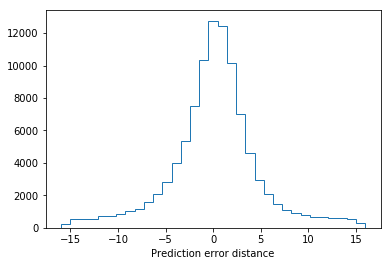

In [79]:
i = 30
plot_distr(filenames[i], i+2)

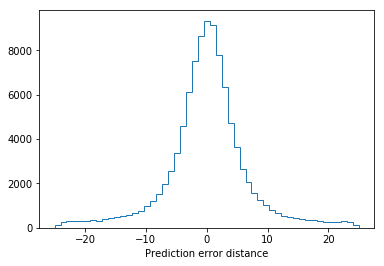

In [80]:
i = 48
plot_distr(filenames[i], i+2)

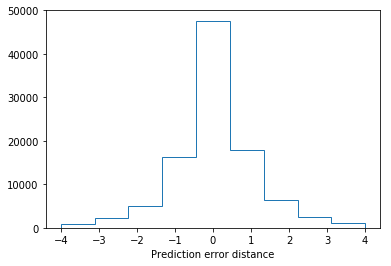

In [81]:
i = 6
plot_distr(filenames[i], i+2)

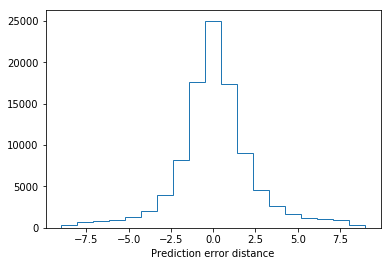

In [82]:
i = 16
plot_distr(filenames[i], i+2)